In [3]:
!pwd

/content


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import tensorflow as tf


In [4]:
IMAGE_DIR = "images-small/"

train_df = pd.read_csv("train-small.csv")
valid_df = pd.read_csv("valid-small.csv")
test_df = pd.read_csv("test.csv")

labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

In [5]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w=320, target_h=320):
    
    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        target_size=(target_w, target_h))

    return generator

In [6]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w=320, target_h=320):
    
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True)

    # fit generator to sample from training data
    image_generator.fit(data_sample)  

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
        dataframe=valid_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h))

    test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h))

    return valid_generator, test_generator

In [ ]:
# train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
# valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

# we can't run because we can not get the images from coursera


In [7]:
def compute_class_freqs(labels):
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [ ]:
# freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
# pos_weights = freq_neg
# neg_weights = freq_pos
# pos_contribution = freq_pos * pos_weights
# neg_contribution = freq_neg * neg_weights


# the numbers of pos samples and neg samples are nit equal in each class, so we need to customize our loss function to balance.

In [8]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):
        loss = 0.0

        for i in range(len(pos_weights)):
            
            # for each class, add average weighted loss for that class
            loss += 0 - K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon) + neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))  
        return loss

    return weighted_loss

In [9]:
base_model = DenseNet121(weights='densenet.hdf5', include_top=False)

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(labels), activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))
# history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=3, valid_generator=valid_generator, validation_steps=25, verbose=1)

# plt.plot(history.history['loss'])
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("Training Loss Curve")
# plt.show()

# just skip the training process


In [12]:
model.load_weights("pretrained_model.h5")

In [36]:
model.summary(line_length=200)
# as we can see, we didn;t specific the input images size, so the weidth and height are both None; it can acces any shape, but the samples in one batch must be of the same shape

Model: "model"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_1 (InputLayer)                                              [(None, None, None, 3)]                     0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)                                    (None, None, None, 3)                       0                       input_1[0][0]                                  

In [25]:
img = np.array(tf.keras.preprocessing.image.load_img('chestxray_sample.png'))

In [26]:
img.shape

(1024, 1024, 3)

In [28]:
mean_ = np.mean(img)

In [29]:
std_ = np.std(img)

In [30]:
img = (img - mean_) / std_

In [32]:
img_ipt = np.expand_dims(img, 0)

In [33]:
result = model.predict(img_ipt)

In [38]:
res = model(img_ipt)

In [40]:
res.shape

TensorShape([1, 14])

In [37]:
layer_name = 'bn'
cls = 7


In [41]:
new_model = Model(model.input, [model.output, model.get_layer(layer_name).output])

In [42]:
res, conv = new_model(img_ipt)

In [44]:
conv.shape

TensorShape([1, 32, 32, 1024])

In [58]:
with tf.GradientTape(persistent=True) as tape:
    y, conv_output = new_model(img_ipt)
    y_c = y[:, cls]


In [59]:
grads = tape.gradient(y_c, conv_output)

In [61]:
grads = grads[0]


In [64]:
grads.shape

TensorShape([32, 32, 1024])

In [51]:
conv_output = conv_output[0]

In [53]:
conv_output.shape

TensorShape([32, 32, 1024])

In [62]:
weights = np.mean(grads, (0, 1))

In [63]:
weights.shape

(1024,)

In [76]:
conv_output = conv_output[0]

In [77]:
cam = np.dot(conv_output, weights)

In [78]:
cam.shape

(32, 32)

In [79]:
import cv2

In [80]:
cam = cv2.resize(cam, (1024, 1024), interpolation=cv2.INTER_LINEAR)

In [81]:
cam = np.maximum(cam, 0)

In [82]:
cam = cam / cam.max()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


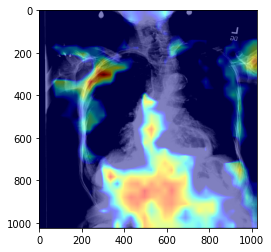

In [84]:
plt.imshow(img, cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)